In [104]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Dataset

In [3]:
df_stock = pd.read_csv('Stock_Market.csv')
df_stock.head()

,Unnamed: 0,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [8]:
df_stock.drop('Unnamed: 0', inplace = True, axis = 1)

### Correlation Between Features

In [9]:
corr = df_stock.corr()
corr

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


<IPython.core.display.Javascript object>


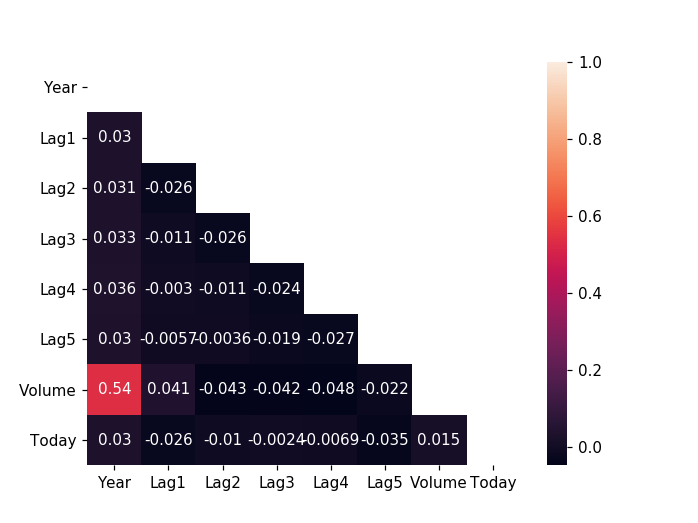

In [12]:
%matplotlib notebook
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask = mask, fmt = '.2g', annot=True)
plt.savefig('correlation.png', dpi = 100)

<IPython.core.display.Javascript object>


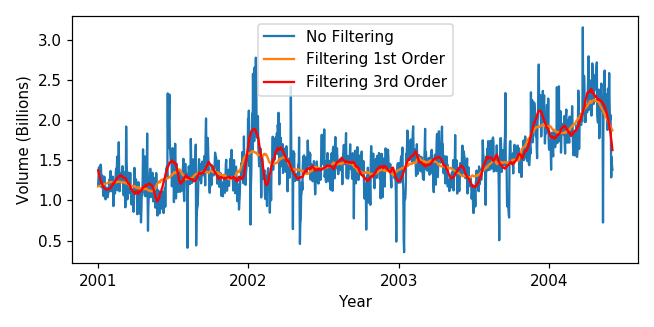

In [32]:
%matplotlib notebook
plt.figure(figsize=(6, 3))
plt.plot(df_stock.index, df_stock['Volume'], label = 'No Filtering')
plt.xticks(np.arange(0, df_stock.index[-1], 365), [2001, 2002, 2003, 2004])  # Set labels.
plt.xlabel('Year')
plt.ylabel('Volume (Billions)')

# To filter data
from scipy.signal import savgol_filter
filtered_data_1st = savgol_filter(np.array(df_stock['Volume']), 61, 1)
plt.plot(df_stock.index, filtered_data_1st, label = 'Filtering 1st Order')

filtered_data_3rd = savgol_filter(np.array(df_stock['Volume']), 61, 3)
plt.plot(df_stock.index, filtered_data_3rd, label = 'Filtering 3rd Order', color = 'r')

plt.legend()

plt.tight_layout()
plt.savefig('Volume_vs_Year.png', dpi = 100)

### Logistic Regression

Using Sklearn

In [81]:
x = df_stock.iloc[:, 1:7].values
y = df_stock['Direction'].values

model_LR = LogisticRegression()
model_LR.fit(x, y)
prediction_LR = model_LR.predict(x)
print('Model Prediction of Direction: ', prediction_LR[:5])
print('Actual dDirection:             ', y[:5])

print('Coeeficients:  ', model_LR.coef_)

Model Prediction of Direction:  ['Up' 'Down' 'Down' 'Up' 'Up']
Actual dDirection:              ['Up' 'Up' 'Down' 'Up' 'Up']
Coeeficients:   [[-0.07284345 -0.04223481  0.0110163   0.00928427  0.01026372  0.13211221]]


Using Statsmodels

In [64]:
x_sm = sm.add_constant(x)
y_sm = [1 if i == 'Up' else 0 for i in y]
logit = sm.Logit(y_sm,x_sm)
results = logit.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1250
Model:                          Logit   Df Residuals:                     1243
Method:                           MLE   Df Model:                            6
Date:                Thu, 03 Sep 2020   Pseudo R-squ.:                0.002074
Time:                        23:57:37   Log-Likelihood:                -863.79
converged:                       True   LL-Null:                       -865.59
Covariance Type:            nonrobust   LLR p-value:                    0.7319
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1260      0.241     -0.523      0.601      -0.598       0.346
x1            -0.0731      0.

In [78]:
sm_prediction = results.predict(x_sm)
print(sm_prediction)
sm_prediction = ['Up' if i>0.5 else 'Down' for i in sm_prediction]
print(sm_prediction[:5])

[0.50708413 0.48146788 0.48113883 ... 0.5392683  0.52611829 0.51791656]
['Up', 'Down', 'Down', 'Up', 'Up']


In [73]:
# Compare coefficients in sklearn and statsmodels
print('Statsmodels Coefficients: \n', results.params)
print('Sklearm Logistic Regression Coefficients: \n', model_LR.coef_[0])

Statsmodels Coefficients: 
 [-0.12600026 -0.07307375 -0.04230134  0.01108511  0.00935894  0.01031307
  0.13544066]
Sklearm Logistic Regression Coefficients: 
 [-0.07284345 -0.04223481  0.0110163   0.00928427  0.01026372  0.13211221]


In [83]:
# Compare predicted direction using sklearn and statmodels
print('Statmodels prediction: ', sm_prediction[:10])
print('Sklearn predictions:   ', prediction_LR[:10])
print('Actual Direction:      ', y[:10])

Statmodels prediction:  ['Up', 'Down', 'Down', 'Up', 'Up', 'Up', 'Down', 'Up', 'Up', 'Down']
Sklearn predictions:    ['Up' 'Down' 'Down' 'Up' 'Up' 'Up' 'Down' 'Up' 'Up' 'Down']
Actual Direction:       ['Up' 'Up' 'Down' 'Up' 'Up' 'Up' 'Down' 'Up' 'Up' 'Up']


In [89]:
# confusion Matrix
conf_sm = confusion_matrix(y, sm_prediction) # confusion matrix of statmodels
conf_sk = confusion_matrix(y, prediction_LR) # confusion matricx of sklearn logistic regression

print('Statmodels confusion matrix: \n', conf_sm)
print('Sklearn confusion matrix: \n', conf_sk)

Statmodels confusion matrix: 
 [[145 457]
 [141 507]]
Sklearn confusion matrix: 
 [[144 458]
 [141 507]]


In [118]:
print('Accuracy score: {}'.format(accuracy_score(y, sm_prediction)))

Accuracy score: 0.5216


Split dataset into train and test

In [125]:
x_train = df_stock[df_stock['Year']<2005].iloc[:, 1:7].values
y_train = df_stock[df_stock['Year']<2005]['Direction'].values
x_test = df_stock[df_stock['Year'] == 2005].iloc[:, 1:7].values
y_test = df_stock[df_stock['Year'] == 2005]['Direction'].values

In [126]:
# train model on train data
x_train = sm.add_constant(x_train)
y_train_ud = [1 if i == 'Up' else 0 for i in y_train]
logit = sm.Logit(y_train_ud,x_train)
results_train = logit.fit()

sm_train_prediction = results_train.predict(x_train)
sm_train_prediction = ['Up' if i>0.5 else 'Down' for i in sm_train_prediction]

# Confusion matrix
conf_sm = confusion_matrix(y, sm_prediction)

Optimization terminated successfully.
         Current function value: 0.691936
         Iterations 4
